Optimization terminated successfully.
         Current function value: 0.544994
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                   78
Model:                          Logit   Df Residuals:                       71
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                  0.1652
Time:                        08:40:51   Log-Likelihood:                -42.510
converged:                       True   LL-Null:                       -50.920
Covariance Type:            nonrobust   LLR p-value:                  0.009961
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1022      2.525      0.832      0.405      -2.847       7.052
Age           

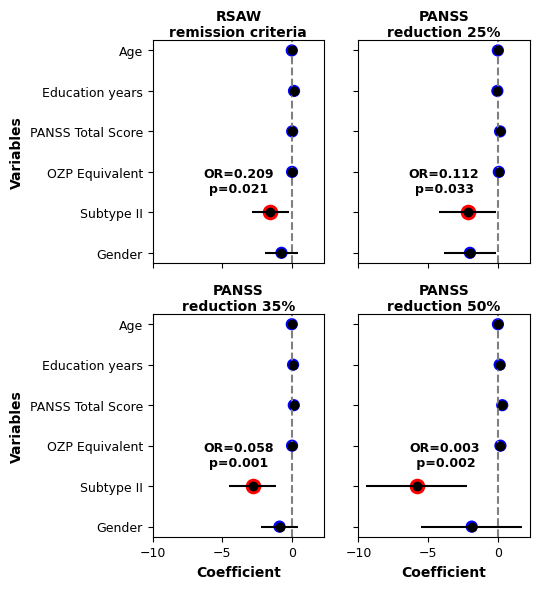

Odds Ratios and Confidence Intervals for RSAW remission criteria:
                         OR      2.5%     97.5%
Age                0.969578 -0.095396  0.033607
Education years    1.137717 -0.043673  0.301721
PANSS Total Score  0.996989 -0.045133  0.039102
OZP Equivalent     0.989340 -0.092788  0.071353
Subtype II         0.208993 -2.896680 -0.234226
Gender             0.462654 -1.963384  0.421831

Odds Ratios and Confidence Intervals for PANSS reduction 25%:
                         OR      2.5%     97.5%
Age                0.989716 -0.099470  0.078796
Education years    0.955299 -0.222215  0.130753
PANSS Total Score  1.160988  0.065579  0.232964
OZP Equivalent     1.060677 -0.067382  0.185197
Subtype II         0.112476 -4.191720 -0.178312
Gender             0.134265 -3.847037 -0.168840

Odds Ratios and Confidence Intervals for PANSS reduction 35%:
                         OR      2.5%     97.5%
Age                0.969116 -0.100153  0.037411
Education years    1.062792 -0.107934  0

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
df = pd.read_excel('data.xlsx')

def fit_logistic_regression(df, group_column, control_vars):
    # 过滤数据,提取Label中0和1
    df_filtered = df[df['Label'].isin([0, 1])].copy()

    # 转换Group变量 (缓解为1,未缓解为0)
    df_filtered[group_column] = df_filtered[group_column].map({1: 1, 2: 0})

    # 将亚组(Label)作为自变量
    df_filtered['Subgroup'] = df_filtered['Label']

    # 对分类变量生成哑变量,包括亚组变量
    df_filtered = pd.get_dummies(df_filtered, columns=['Gender', 'Subgroup'], drop_first=True)

    # 自变量筛选,仅保留显著性较高的变量,并加入 'Gender_2'
    selected_vars = ['Age', 'Education_years', 'PANSS-T', 'OZP Equivalent', 'Subgroup_1', 'Gender_2']
    X = df_filtered[selected_vars]

    # 因变量
    y = df_filtered[group_column]

    # 添加常数项
    X = sm.add_constant(X)

    # 拟合逻辑回归模型
    model = sm.Logit(y, X)
    result = model.fit()

    # 输出模型摘要
    print(result.summary())

    # 计算系数、置信区间和 OR
    coef = result.params
    conf = result.conf_int()
    conf['coef'] = coef
    conf.columns = ['2.5%', '97.5%', 'coef']
    
    odds_ratios = np.exp(result.params)
    conf['OR'] = odds_ratios
    
    # 移除 Const 行
    conf = conf.drop(index='const', errors='ignore')
    
    return conf, result

def plot_combined_coefficients(conf_list, labels, annotations, suptitle=''):
    # 创建变量名映射字典
    variable_names = {
        'Education_years': 'Education years',
        'Subgroup_1': 'Subtype II',
        'PANSS-T': 'PANSS Total Score',
        'Age': 'Age',
        'Gender_2': 'Gender'
    }
    
    # 以第二个模型的变量名称为准构建Y轴标签
    y_labels = [variable_names.get(var, var) for var in conf_list[1].index]
    
    # 创建子图，2x2布局，共享Y轴
    fig, axes = plt.subplots(2, 2, figsize=(5.5, 6), sharex=True, sharey='row')
    
    for i, (conf, label, annotation) in enumerate(zip(conf_list, labels, annotations)):
        # 计算当前子图的行和列索引
        row = i // 2
        col = i % 2
        
        # 更新所有图的Y轴变量为第二张图的Y轴变量
        conf.index = y_labels
        
        # 绘制点图
        sns.pointplot(x='coef', y=conf.index, data=conf, join=False, markers='o', color='blue', ax=axes[row, col])
        axes[row, col].errorbar(x=conf['coef'], y=conf.index, 
                         xerr=[conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']], 
                         fmt='o', color='black')
        axes[row, col].axvline(0, color='gray', linestyle='--')
        axes[row, col].set_title(label, fontsize=10, fontweight='bold', loc='center', y=0.98)
        
        # 设置X轴标签，只在底部行显示
        if row == 1:  # 底部行
            axes[row, col].set_xlabel('Coefficient', fontsize=10, fontweight='bold')
        else:
            axes[row, col].set_xlabel('')
            
        # 设置Y轴标签，只在左侧列显示
        if col == 0:  # 左侧列
            axes[row, col].set_ylabel('Variables', fontsize=10, fontweight='bold')
        else:
            # 隐藏右侧列的Y轴刻度标签
            axes[row, col].tick_params(axis='y', labelleft=False)
            axes[row, col].set_ylabel('')

        # 调整刻度标签字体大小
        axes[row, col].tick_params(axis='y', labelsize=9)
        axes[row, col].tick_params(axis='x', labelsize=9)

        # 高亮显示 Subtype 变量,并在固定位置(0.5, 0.5)添加注释
        for var in conf.index:
            if 'Subtype' in var:
                color = 'red' if conf.loc[var, '2.5%'] > 0 or conf.loc[var, '97.5%'] < 0 else 'green'
                axes[row, col].scatter(conf.loc[var, 'coef'], var, color=color, s=150, edgecolor='white')
                if color == 'red':
                    # 在图中心位置(0.5, 0.5)添加注释
                    axes[row, col].text(
                        0.5, 0.5,  # 位置设为0.5, 0.5
                        annotation,
                        transform=axes[row, col].transAxes,  # 使用轴的相对坐标系
                        verticalalignment='center',
                        horizontalalignment='center',
                        fontsize=9,
                        color='black',
                        fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
                    )
    
    # 调整布局，确保所有内容都能显示
    plt.tight_layout()
    
    # 添加总标题并调整位置
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight='bold', y=0.98)
        plt.subplots_adjust(top=0.92)
    
    # 保存图像
    plt.savefig('combined_coef_plot.jpg', dpi=1200, bbox_inches='tight')
    plt.show()

# 定义需要控制的变量
control_vars = ['Age', 'Education_years', 'PANSS-T', 'OZP Equivalent', 'Subgroup_1', 'Gender_2']

# 拟合四个不同条件下的逻辑回归模型系数
conf1, result1 = fit_logistic_regression(df, 'Group', control_vars)
conf2, result2 = fit_logistic_regression(df, 'PANSS duction 0.25', control_vars)
conf3, result3 = fit_logistic_regression(df, 'Group2', control_vars)
conf4, result4 = fit_logistic_regression(df, 'Group3', control_vars)

# 定义每个图的注释内容
annotations = [
    '\n\n\n\nOR=0.209\np=0.021',  # RSAW注释
    '\n\n\n\nOR=0.112\np=0.033',  # PANSS 25%注释
    '\n\n\n\nOR=0.058\np=0.001',  # PANSS 35%注释
    '\n\n\n\nOR=0.003\n p=0.002'   # PANSS 50%注释
]

# 绘制组合图，2x2布局，注释放在(0.5, 0.5)位置，共享Y轴
plot_combined_coefficients(
    [conf1, conf2, conf3, conf4], 
    ['RSAW\nremission criteria', 'PANSS\nreduction 25%', 'PANSS\nreduction 35%', 'PANSS\nreduction 50%'], 
    annotations, 
    suptitle=''
)

# 打印odds ratios和置信区间
print("Odds Ratios and Confidence Intervals for RSAW remission criteria:")
print(conf1[['OR', '2.5%', '97.5%']])

print("\nOdds Ratios and Confidence Intervals for PANSS reduction 25%:")
print(conf2[['OR', '2.5%', '97.5%']])

print("\nOdds Ratios and Confidence Intervals for PANSS reduction 35%:")
print(conf3[['OR', '2.5%', '97.5%']])

print("\nOdds Ratios and Confidence Intervals for PANSS reduction 50%:")
print(conf4[['OR', '2.5%', '97.5%']])